# Data Project - Demography

The following project concerns the study of demography and the composition of the population divided into age and gender. The underlying data for this project is based on past data and projections for the future.
Please note that genereally there is a statistic uncertainty regarding the projections,since they are based on assumptions made for future developments in fertility, mortality and migration. This is subject to uncertainty. The further out in the future, the greater the uncertainty is.
The data, which is being used in this project is fetched directly from the two data sets "FRDK118" and "FOLK2" from Danmarks Statistik, DST.

The data will be visualized in the form of an interactive population pyramid, showing the age and gender distribution throughout the years spanning from 1980 to 2060 for the total population of Denmark.

**!! Before running the project, the package “plotly” and "pydst" should be installed!!**

Paste *pip install plotly* in the Terminal. This is a necessity in order to view the figures and tables. 
See https://plot.ly/python/getting-started/ for help.

Paste *pip install git+https://github.com/elben10/pydst* in the Terminal.

# The data

In [1]:
# Import relevant packages
import os
import pydst
import pandas as pd
import numpy as np

In [2]:
dst = pydst.Dst(lang='da')

# make pickle path if not already existing
try:
    os.makedirs("pickles")
except:
    pass

## Fetch data from DST  ##
First the two data sets are being fetched directly from DST and saved as pickles to speed up the computing. The columns are renamed as well.

**It might take some time to fetch the data the first time you are running this code!**

In [3]:
#########################
# POPULATION PROJECTION #
#########################

# if a pickle exists, unpickle it
# otherwise get and process the data anew

population_projection = None
if os.path.isfile("pickles/population_projection.pickle"):
    population_projection = pd.read_pickle("pickles/population_projection.pickle")
else:
    raw_data = None
    if os.path.isfile("pickles/raw_data_frdk118.pickle"):
        raw_data = pd.read_pickle("pickles/raw_data_frdk118.pickle")
    else:
        # Fetch data from DST and save as raw_data
        raw_data = dst.get_data(
            table_id = 'FRDK118',
            variables={
                "KØN" : ["*"],
                "ALDER" : ["*"], 
                "TID" :["*"], 
                "HERKOMST" : ["*"]})
        raw_data.to_pickle("pickles/raw_data_frdk118.pickle")

    #create a copy
    population_projection = raw_data.copy()
    
    # rename columns
    population_projection = population_projection.rename(columns = {
        "KØN": "gender",
        "ALDER": "age",
        "TID": "year",
        "HERKOMST": "origin",
        "INDHOLD": "count"
    })
    
    # map gender to M/F
    population_projection["gender"] = population_projection["gender"].map({
        "Mænd": "M",
        "Kvinder": "F"
    })
    
     # map dst's year to actual int years
    population_projection["age"] = population_projection["age"].map(lambda year : int(year.split(' ', 1)[0]))
    
    # save to pickle
    population_projection.to_pickle("pickles/population_projection.pickle")

In [4]:
## Group data by gender, age and year then sum over count
population_projection_grouped = population_projection.groupby(["gender", "age", "year"])
population_projection_grouped_sum = population_projection_grouped.agg("sum").reset_index()

In [5]:
#########################
# POPULATION HISTORY #
#########################

# if a pickle exists, unpickle it
# otherwise get and process the data anew

population_history = None
if os.path.isfile("pickles/population_history.pickle"):
    population_history = pd.read_pickle("pickles/population_history.pickle")
else:
    raw_data = None
    if os.path.isfile("pickles/raw_data_folk2.pickle"):
        raw_data = pd.read_pickle("pickles/folk2.pickle")
    else:
        # Fetch data from DST and save as raw_data
        raw_data = dst.get_data(
            table_id = 'FOLK2',
            variables={
                "KØN" : ["*"],
                "ALDER" : ["*"], 
                "TID" :["*"], 
                "HERKOMST" : ["*"], 
                "STATSB" : ["*"],
                "IELAND" : ["*"]})
        raw_data.to_pickle("pickles/raw_data_folk2.pickle")

    # create a copy
    population_history = raw_data.copy()
    
    # rename columns
    population_history = population_history.rename(columns = {
        "KØN": "gender",
        "ALDER": "age",
        "TID": "year",
        "HERKOMST": "origin",
        "STATSB" : "citizenship",
        "IELAND" : "country of origin",
        "INDHOLD": "count"
    })
    
    # map gender to M/F
    population_history["gender"] = population_history["gender"].map({
        "Mænd": "M",
        "Kvinder": "F"
    })
    
     # map dst's year to actual int years
    population_history["age"] = population_history["age"].map(lambda year : int(year.split(' ', 1)[0]))
    
    # save to pickle
    population_history.to_pickle("pickles/population_history.pickle")


## More data editing
Next the unnecessary columns are being removed by grouping over the desired columns. There were two overlapping years, which are being removed as well.

In [ ]:
## Group data by gender, age and year then sum over count

population_history_grouped = population_history.groupby(["gender", "age", "year"])
population_history_grouped_sum = population_history_grouped.agg("sum").reset_index()

## Delete the overlapping years
population_history_grouped_sum = population_history_grouped_sum[population_history_grouped_sum["year"] != 2019]
population_history_grouped_sum = population_history_grouped_sum[population_history_grouped_sum["year"] != 2018]

In [ ]:
## Create a variable that contains all data by concatenating the two data sets

population = population_history_grouped_sum.append(population_projection_grouped_sum)

In [ ]:
# Seperates the two genders by creating two seperate variables.

pop_men = population[population["gender"] == 'M']
pop_women = population[population["gender"] == 'F']

## Create dictionary for each year
A dictionary is being created, which for each year contains a tuple of men and women for each age.

In [ ]:
# Find min and max value for the column "year"
min_year = np.min(population['year'])
max_year = np.max(population['year'])

# create dictionary for each year
year_to_pop = {}
for i in range(min_year,max_year + 1):
    year = str(i)
    men = np.array(pop_men[pop_men["year"] == i]["count"].tolist())
    women = np.array(pop_women[pop_women["year"] == i]["count"].tolist())
    year_to_pop[year] = (men, women)

# The visualization
The data is being visualized through a population pyramid.
Some of the advantages of using a population pyramid is the following:
* One gets an insight into the composition of the population subdivided into age and gender (<16, 16-66, >66) 
* Indicates type of population structure, which can be used for future predictions 
* It shows whether the population surplus is due to men or women
* The population can reveal changes in birth and death rates
* It can reveal the impact of migration and events (i.e. epidemics and war)


In [ ]:
# Import more packages for visualization
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets


py.offline.init_notebook_mode(connected=True)

## Creating the population pyramid
An interactive population pyramid is begin created together with a slider, which allows you to see the change of the population structure for each year.

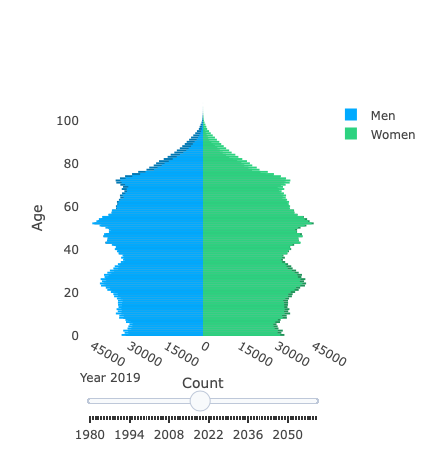

In [ ]:
# the year the graph will initially show
initial_year = 2019

# the y range
y = list(range(0, 120, 1))

# colours for pyramid 
lightblue = "hsl(200, 100%, 50%)"
darkblue = "hsl(200, 100%, 35%)"
lightgreen = "hsl(150, 65%, 50%)"
darkgreen = "hsl(150, 65%, 35%)"

# Create four bars using the year_to_pop data.
data = []

for year, (men, women) in year_to_pop.items():
    (men_inv, women_inv) = (men * -1, women * -1)
    isVisible = year == str(initial_year)
    data.extend([
        go.Bar(y=y,
               x=women_inv,
               visible = isVisible,
               orientation='h',
               hoverinfo='none',
               showlegend=False,
               marker=dict(color=darkblue)               ),
        go.Bar(y=y,
               visible = isVisible,
               x=men_inv,
               orientation='h',
               name='Men',
               hoverinfo='x',
               marker=dict(color=lightblue)
               ),
        go.Bar(y=y,
               x=men,
               visible = isVisible,
               orientation='h',
               showlegend=False,
               hoverinfo='none',
               marker=dict(color=darkgreen)
               ),
        go.Bar(y=y,
               x=women,
               visible = isVisible,
               orientation='h',
               name='Women',
               hoverinfo='x',
               marker=dict(color=lightgreen)
               )
    ])
    
# Construct the slider

steps = []

for i in range(len(year_to_pop)):
    year = dict(
        method = "restyle",
        args = ["visible", [False] * len(year_to_pop) * 4],
        label=str(i + 1980)
    )
    year["args"][1][i*4 + 0] = True
    year["args"][1][i*4 + 1] = True
    year["args"][1][i*4 + 2] = True
    year["args"][1][i*4 + 3] = True
    steps.append(year)

sliders = [dict(
    active = initial_year - 1980,
    currentvalue = {"prefix": "Year "},
    pad = {"t": 30},
    steps = steps
    
)]
## Layout of the pyramid
layout = dict(
    sliders = sliders,
    yaxis = go.layout.YAxis(title = "Age"),
    xaxis = go.layout.XAxis(
        range = [-40000, 40000],
        tickvals = [-45000, -30000, -15000, 0, 15000, 30000, 45000],
        ticktext = [45000, 30000, 15000, 0, 15000, 30000, 45000],
        title = "Count",
        autorange = True,
    ),
    barmode = "overlay",
    bargap = 0.1
)

    
fig = go.Figure(data=data, layout=layout)

py.offline.iplot(fig)

The above population pyramid shows the distribution of age and gender throughout the years. The darker coloured bars show the difference between men and women for a given year. E.g. The dark blue coloured bars represent the excess amount of women compared to men.

As we slide through the years, we see a growing amount of elders above the age of 66 and a smaller workforce.

## Table visualization ##
In order to see the development more precisely, the table below also shows the change in structure of the population throughtout the years.

In [ ]:
# Create a table 

def create_table(data):
    men, women = data
    pop = [sum(ns) for ns in zip(men, women)]
    dist = {}
# Count loop for three age groups
    for age, count in enumerate(pop):
        if age < 16:
            dist["u16"] = dist.get("u16", 0) + count
            continue
        elif age < 66:
            dist["u66"] = dist.get("u66", 0) + count
        else:
            dist["o66"] = dist.get("o66", 0) + count

    total = sum(dist.values())
    # Construct percentages
    percentages = { k: f"{(count / total * 100):.2f}%" for k, count in dist.items() }
    dist = { k: f"{(count/1000):.2f}" for k, count in dist.items() }
    
    # Create the table by constructing a DataFrame with the below values
    frame = pd.DataFrame(
        data = {
            "Age": ["66+", "16-66", "<16", "Total"],
            "Thousands": [dist["o66"], dist["u66"], dist["u16"], total / 1000],
            "Percentages": [percentages["o66"], percentages["u66"], percentages["u16"], "100%"]
        }
    )

    return frame

In [ ]:
## Layout for table and interactive slider

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def render(year):
    return create_table(year_to_pop[str(year)])

slider = widgets.IntSlider(
    value=2019,
    min=1980,
    max=2060,
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

interact(render, year=slider);

interactive(children=(IntSlider(value=2019, description='Year:', max=2060, min=1980), Output()), _dom_classes=…

The table above clearly shows that the percentage of people under the age of sixteen has been falling since 1980 and is projected to continue to do so all the way until 2060. The percentage of people in the workforce from the age 16-66 was increasing until 1994 but has ever since had a downward slope and is projected to continue like this. Elders above the age of 66 have continuously increased.

## Consequences of the demographic development 

The demographic development has a huge impact for the public sector and finance.
The increasing amount elders will affect the public expenditure, meaning the increasing amount of people receiving public pension. The tax revenue will be affected by the diminishing amount of people in the workforce. 
